<a href="https://colab.research.google.com/github/AEResearch/NasRepos/blob/master/WorkingUKFNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UKF Optimization for a Neural Network

### Two Core Components:
1. The UKF Library

2. The UKF Implementation 



Notes: Need to breakdown the hwx model 

## Setting Up the Library

In [14]:
from pprint import pformat
import numpy as np
import matplotlib.pyplot as plt
!pip install filterpy
from filterpy.kalman import KalmanFilter, UnscentedKalmanFilter, MerweScaledSigmaPoints, unscented_transform
import ukf
import utility
from keras.models import Sequential
from keras.layers import Dense, Dropout
import math, os, time, logging
from sklearn.metrics import mean_squared_error
from keras.callbacks import Callback

## Set up UKF

In [15]:
# Application of Kalman filter using a Python lib

class EpochInfoTracker(Callback):
    def __init__(self):
        self.weights_history = []

    def on_epoch_end(self, epoch, logs=None):
        weights_vec = get_weights_vector(self.model)
        self.weights_history.append(weights_vec)


class Params:
    pass


params = Params()
params.epochs = 12
params.train_series_length = 500
params.test_series_length = 1000
params.mg_tau = 30
params.window_size = 12    # M
params.ukf_dt = 0.1
params.alpha, params.beta, params.kappa = 1, 2, 1  # Worked well
# params.alpha, params.beta, params.kappa = 0.001, 2, 1
params.Q_var = 0.001
params.R_var = 0.001

# To make training data and related variables accessible across functions
params.train_ukf_ann = True
params.X_data = None
params.y_data = None
params.hxw_model = None
params.curr_idx = 0


def measurement_func(w, x):
    hxw_model = params.hxw_model
    set_weights(hxw_model, w)
    hxw = hxw_model.predict(x.reshape(1, len(x)))   # Reshape needed to feed x as 1 sample to ANN model
    hxw = hxw.flatten() # Flatten to make shape = (1,)
    return hxw


def fw(w, dt=None):
    return w    # Identity


def hw(w):
    x = params.X_data[params.curr_idx]
    hxw = measurement_func(w, x)
    return hxw


def create_ukf(Q, R, dt, w_init, P_init):
    M = w_init.shape[0]

    points = MerweScaledSigmaPoints(M, params.alpha, params.beta, params.kappa)

    ukf = UnscentedKalmanFilter(dim_x=M, dim_z=1, dt=dt, fx=fw, hx=hw, points=points)
    ukf.x = w_init
    ukf.P = P_init
    ukf.R = R
    ukf.Q = Q

    return ukf


def create_my_ukf(Q, R, dt, w_init, P_init):
    my_ukf = ukf.UnscentedKalmanFilter(fw, hw, R, Q, w_init, P_init, params.alpha, params.beta, params.kappa)
    return my_ukf


## Tools for Generating Dataset


In [16]:
def prepare_dataset(series, M, stride):
    X, y = [], []
    for i in range(0, len(series) - M - 1, stride):
        window = series[i:(i + M)]  #
        X.append(window)
        y.append(series[i + M])
    return np.array(X), np.array(y)

## Tools for Creating Neural Net

In [17]:
def evaluate_neural_nets(sgd_ann, ukf_ann, window, use_train_series=False, train_series=None):
    if use_train_series:
        X_data, y_data = params.X_data, params.y_data
        series = train_series
        sample_len = params.train_series_length
        title = "Train series (true vs. predicted)"
    else:
        sample_len = params.test_series_length
        series = utility.mackey_glass(sample_len=sample_len, tau=params.mg_tau)
        series = np.array(series[0]).reshape((sample_len))
        X_data, y_data = prepare_dataset(series, window, stride=1)
        title = "Test series (true vs. predicted)"
    ukf_pred, ukf_self_pred = utility.predict_series(ukf_ann, X_data, sample_len, window)

    utility.plot(range(sample_len), series, title=title, label='True series')
    utility.plot(range(sample_len), ukf_pred, new_figure=False, label='UKF ANN prediction (based on true windows)')

def create_neural_net(M):
    ann = Sequential()
    ann.add(Dense(1, input_dim=M, activation='tanh'))  # output (x_k) - no activation because we don't want to limit the range of output
    ann.compile(optimizer='sgd', loss='mse')
    ann.summary()
    return ann


def get_weights_vector(model):
    weights = model.get_weights()
    # logging.info(weights)
    weights_vec = []
    for w_mat in weights:
        weights_vec.extend(w_mat.reshape(w_mat.size))

    weights_vec = np.array(weights_vec)
    return weights_vec


def set_weights(model, weights_vec):
    prev_weights = model.get_weights()
    # logging.info(prev_weights)
    new_weights = []
    start = 0

    for prev_w_mat in prev_weights:
        end = start + prev_w_mat.size
        new_w_mat = np.array(weights_vec[start: end]).reshape(prev_w_mat.shape)
        new_weights.append(new_w_mat)
        start = end

    model.set_weights(new_weights)

## Prepare Dataset 

In [18]:
dt = 0.01
n_samples = params.train_series_length
X_series = utility.mackey_glass(sample_len=n_samples, tau=params.mg_tau, n_samples=window)
X_series = np.array(X_series[0]).reshape((n_samples))

params.X_data, params.y_data = prepare_dataset(X_series, window, stride=1)

## Creating Neural Net

In [19]:
params.hxw_model = create_neural_net(window)
w_init = get_weights_vector(params.hxw_model)
num_weights = w_init.shape[0]

ukf_ann = create_neural_net(window)
ukf_ann.set_weights(params.hxw_model.get_weights())


ukf_w = np.zeros((num_weights, params.epochs))
ukf_train_mse = np.zeros(params.epochs)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1)                 13        
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1)                 13        
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


## UKF Parameters

In [ ]:
P_init = 0.1 * np.eye(num_weights)
Q = params.Q_var * np.eye(num_weights)
R = np.array([[params.R_var]])

z_true_series = params.y_data
num_iter = params.epochs * len(z_true_series)

ukf_filter = create_ukf(Q, R, dt, w_init, P_init)

## UKF Training Loop

2020-07-19 00:44:49,552 [INFO] Training neural net with UKF
2020-07-19 00:49:45,478 [INFO] Training complete. time_to_train = 295.93 sec, 4.93 min
2020-07-19 00:49:45,479 [INFO] Training neural net with SGD
2020-07-19 00:49:45,482 [INFO] Training SGD complete
2020-07-19 00:49:45,483 [INFO] Visualize evolution of UKF ANN weights
2020-07-19 00:49:45,547 [INFO] Visualize evolution of SGD ANN weights
2020-07-19 00:49:45,548 [INFO] Visualize evolution of true y vs. hxw(x,w)
2020-07-19 00:49:45,558 [INFO] Evaluating and visualizing neural net predictions


All figures saved to output


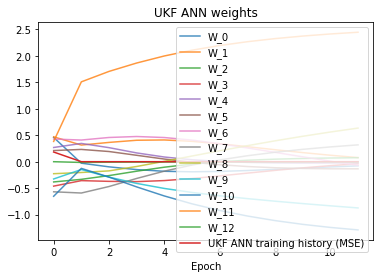

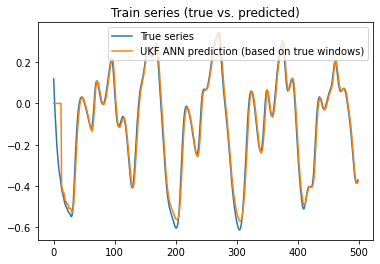

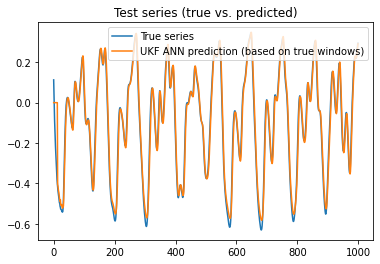

In [20]:
utility.setup_logging('output')
window = params.window_size

epoch = 0

for i in range(num_iter):
    idx = i % len(z_true_series)
    if idx == 0:
        if not params.train_ukf_ann:
            break

        preds = ukf_ann.predict(params.X_data)
        mse = mean_squared_error(z_true_series, preds)
        ukf_train_mse[epoch] = mse

        ukf_w[:, epoch] = ukf_filter.x[:]

        epoch += 1

    params.curr_idx = idx  

    ukf_filter.predict()

    z = z_true_series[idx]
    ukf_filter.update(z)

    set_weights(params.hxw_model, ukf_filter.x)
    set_weights(ukf_ann, ukf_filter.x)

info_tracker = EpochInfoTracker()
callbacks = [info_tracker]

x_var = range(params.epochs)
utility.plot(x_var, ukf_w[0, :], xlabel='Epoch',
             title='UKF ANN weights', label='W_0', alpha=0.8)
for j in range(1, ukf_w.shape[0]):
    utility.plot(x_var, ukf_w[j, :], new_figure=False,
                 label='W_' + str(j), alpha=0.8)

x_var = range(params.epochs)

utility.plot(x_var, ukf_train_mse, new_figure=False,
             label='UKF ANN training history (MSE)')

evaluate_neural_nets(None, ukf_ann, window,
                     use_train_series=True, train_series=X_series)
evaluate_neural_nets(None, ukf_ann, window)

utility.save_all_figures('output')
plt.show()
